In [2]:
pip install numpy pandas scikit-learn pyro-ppl causalml econml pgmpy dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/3

In [3]:
#Load the librarys
import numpy as np
import pandas as pd
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.model_selection import train_test_split
#from causalml.inference.tree import CausalForest
from dowhy import CausalModel
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from econml.dml import CausalForestDML
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro
import torch

In [4]:
from dowhy import gcm

In [5]:
import networkx as nx

In [6]:
# Simulate some credit risk data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, size=(n, 3))  # 3 features: credit score, income, loan amount
T = np.random.binomial(1, p=0.5, size=(n,))  # Treatment: 0 (low interest rate), 1 (high interest rate)
Y = (X[:, 0] * 0.8 - X[:, 1] * 0.3 + T * 1.5 + np.random.normal(0, 1, size=n)) > 0  # Outcome: default or not
data = pd.DataFrame(np.column_stack([X, T, Y]), columns=["credit_score", "income", "loan_amount", "interest_rate", "default"])


In [7]:
data.head()

,credit_score,income,loan_amount,interest_rate,default
0,0.496714,-0.138264,0.647689,1.0,1.0
1,1.523030,-0.234153,-0.234137,1.0,1.0
2,1.579213,0.767435,-0.469474,0.0,1.0
3,0.542560,-0.463418,-0.465730,1.0,1.0
4,0.241962,-1.913280,-1.724918,0.0,1.0


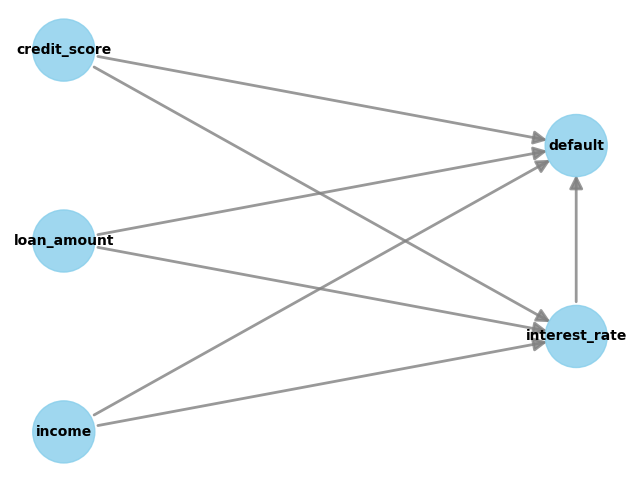

In [5]:
model.view_model()

In [8]:
# Define the SCM using DoWhy and specify the causal graph
model = CausalModel(
    data=data,
    treatment="interest_rate",
    outcome="default",
    common_causes=["credit_score", "income", "loan_amount"],
    instruments=None  # You can add instruments for IV methods
)

# Identify causal effect
identified_estimand = model.identify_effect()

# Estimate the effect using propensity score matching
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
print("Estimated Causal Effect:", estimate.value)

Estimated Causal Effect: 0.401


In [9]:
causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('loan_amount', 'interest_rate'), ('interest_rate', 'default')])) # X -> Y -> Z
gcm.auto.assign_causal_mechanisms(causal_model, data)

In [10]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node default: 100%|██████████| 3/3 [00:00<00:00, 53.94it/s]


Finally, let’s perform an intervention on X. Here, we explicitly perform the intervention
: X=1

In [20]:
#Interventions

samples = gcm.interventional_samples(causal_model,
                                     {'loan_amount': lambda loan_amount: 1},
                                     num_samples_to_draw=500)
samples.head(2)

,loan_amount,interest_rate,default
0,1,0,0
1,1,-1,0


In [23]:
samples = gcm.interventional_samples(causal_model,
                                     {'loan_amount': lambda loan_amount: loan_amount + 0.5},
                                     num_samples_to_draw=500)
samples.head(2)

,loan_amount,interest_rate,default
0,0.660018,-1,0
1,2.348956,0,0


In [24]:
#Counterfactuals
gcm.counterfactual_samples(
    causal_model,
    {'loan_amount': lambda loan_amount: 50},
    observed_data=pd.DataFrame(data=dict(loan_amount=[52], interest_rate=[5], default=[0])))

,loan_amount,interest_rate,default
0,50,5,0


In [ ]:
# Important Libraries

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Data Engineering


In [6]:
# @title Importing the Data
# The raw link to the CSV file in the GitHub repository
url = 'https://raw.githubusercontent.com/dzrich/PhD_Research_in_CausalML/main/Data/CreditRiskDataset.csv'

# Load the CSV file into a pandas DataFrame
CreditRiskDataset = pd.read_csv(url)

# Display the first few rows of the dataset
print(CreditRiskDataset.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                           3  

## First Look at the data:
Looking the Type of Data
Null Numbers
Unique values
The first rows of our dataset


In [7]:
#Searching for Missings,type of data and also know the shape of data
print(CreditRiskDataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
 12  OTHER_DEBT                  32581 non-null  float64
 13  TIME_WITH_BANK              325

#### Drop unwanted Columns

In [8]:
df = CreditRiskDataset.drop(['Unnamed: 15','Unnamed: 16'], axis=1)

#### Impute missing values

In [9]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].mean())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].mean())

# Perfom Some explorations:
 - Starting by distribuition of column Age.
 - Some Seaborn graphical
 - Columns crossing

**Let's start looking through target variable and their distribuition

Text(0.5, 0, 'Default Status')

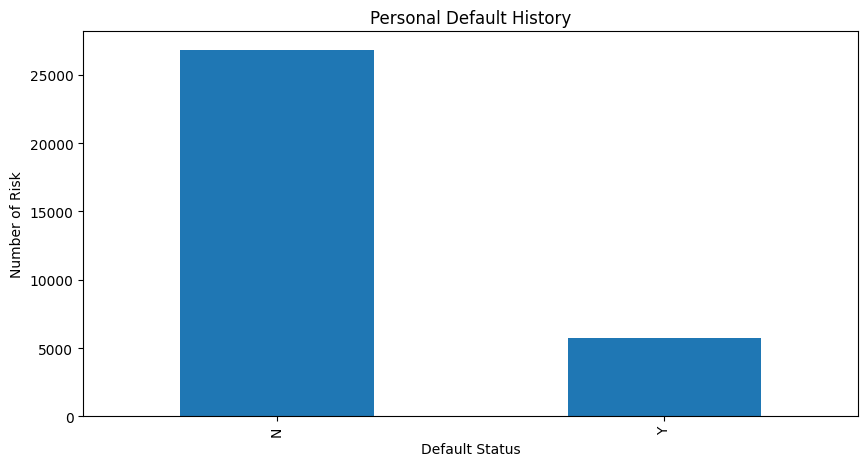

In [12]:
df.cb_person_default_on_file.value_counts().plot(kind='bar', figsize =(10,5))
plt.title("Personal Default History")
plt.ylabel('Number of Risk')
plt.xlabel('Default Status')

In [13]:
df_good = df.loc[df["cb_person_default_on_file"] == 'N']['person_age'].values.tolist()
df_bad = df.loc[df["cb_person_default_on_file"] == 'Y']['person_age'].values.tolist()
df_age = df['person_age'].values.tolist()

Text(0.5, 0, 'Age')

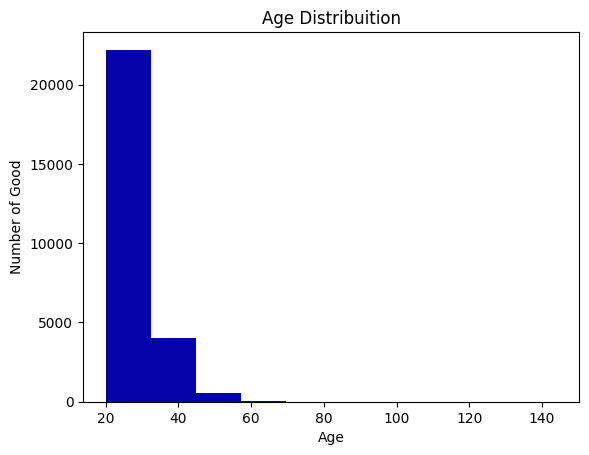

In [15]:
trace0 = plt.hist( x= df_good,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='N',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Good')
plt.xlabel('Age')

In [ ]:
# Step 1: Data Engineering
def data_engineering(CreditRiskDataset):
    # Example: Data cleaning, feature engineering, handling missing values, etc.
    # This step will vary depending on your dataset and use case.
    CreditRiskDataset = CreditRiskDataset.dropna()
    # Feature selection and engineering
    # Example: Assume 'X' are features and 'y' is the target
    X = CreditRiskDataset.drop('cb_person_default_on_file', axis=1)
    y = CreditRiskDataset['cb_person_default_on_file']
    return X, y

In [ ]:
# Step 2: Correlational ML Techniques - Training Correlational ML Models
def train_corr_ml_model(X_train, y_train):
    # Example: Random Forest Classifier
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

In [ ]:
pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 10.1 MB/s eta 0:00:00


In [ ]:
import dowhy
from dowhy import CausalModel

In [ ]:
# Step 3: Causal ML Techniques - Training Causal ML Models
def train_causal_ml_model(X_train, y_train, CreditRiskDataset):
    # Using DoWhy for causal inference
    # Define the causal model
    causal_model = CausalModel(
        CreditRiskDataset=CreditRiskDataset,
        treatment="treatment",  # Placeholder; adjust as needed
        outcome="outcome",  # Placeholder; adjust as needed
        common_causes=["common_cause1", "common_cause2"]  # Placeholder; adjust as needed
    )
    # Identify causal effect
    identified_estimand = causal_model.identify_effect()
    # Estimate the causal effect
    causal_estimate = causal_model.estimate_effect(identified_estimand)
    return causal_estimate

In [ ]:
# Step 4: Performance Evaluation
def evaluate_model(model, X_test, y_test):
    # Using accuracy and F1-score for evaluation
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, f1

In [ ]:
# Step 5: Main Execution Workflow
def main():
    # Load Data (placeholder for actual dataset)
    # The raw link to the CSV file in the GitHub repository
    url = 'https://raw.githubusercontent.com/dzrich/PhD_Research_in_CausalML/main/Data/CreditRiskDataset.csv'

    # Load the CSV file into a pandas DataFrame
    CreditRiskDataset = pd.read_csv(url)


    # Data Engineering
    X, y = data_engineering(CreditRiskDataset)

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Correlational ML Model
    corr_model = train_corr_ml_model(X_train, y_train)
    corr_accuracy, corr_f1 = evaluate_model(corr_model, X_test, y_test)
    print(f"Correlational Model Accuracy: {corr_accuracy}, F1-Score: {corr_f1}")
if __name__ == "__main__":
    main()


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
print(X_train.head(5))


NameError: name 'X_train' is not defined

In [ ]:
 # Train Causal ML Model (Placeholder - actual implementation depends on data specifics)
    causal_estimate = train_causal_ml_model(X_train, y_train, CreditRiskDataset)
    print(f"Causal Estimate: {causal_estimate.value}")

    # Generalizability Check (Example Decision Logic)
    if corr_accuracy > 0.8:  # Threshold for generalizability - adjust based on context
        print("Correlational ML Model is generalizable. Deploying...")
    elif causal_estimate.value > 0.1:  # Example threshold for causal model
        print("Causal ML Model is generalizable. Deploying...")
    else:
        print("Models are not generalizable. Reiterate data engineering or model training steps.")

if __name__ == "__main__":
    main()

https://github.com/dzrich/PhD_Research_in_CausalML/tree/main/Data